In [2]:
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax.example_libraries.stax import Dense, Relu, serial
import pandas as pd
import optax

In [3]:
from model.nn import RealNVP, make_transform
from model.loss import make_error_loss

In [4]:
dim = 3
nlayers = 4
hidden = 6
activation = Relu

transform = make_transform(hidden, activation)
flow_init = RealNVP(transform, nlayers)

rng = jax.random.PRNGKey(42)
init_rng, rng = jax.random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, dim)

phi0 = lambda tau: jnp.array(1.0, dtype=jnp.float64)
phi1 = lambda tau: jnp.linalg.norm(tau)
basis = lambda tau: jnp.array([1.0, jnp.linalg.norm(tau)])
_, train_loss, coefficients = make_error_loss(flow_forward, basis, "./h2o/h2opes_analytic_train.txt")
valid_loss, _, _ = make_error_loss(flow_forward, basis, "./h2o/h2opes_analytic_valid.txt")
test_loss, _, _ = make_error_loss(flow_forward, basis, "./h2o/h2opes_analytic_test.txt")
value_and_grad = jax.value_and_grad(train_loss, argnums=0, has_aux=False)

step_size = 1e-4

params_optimizer = optax.adam(step_size)
params_opt_state = params_optimizer.init(params)

In [5]:
@jax.jit
def step(params, params_opt_state):
    value, grad = value_and_grad(params)
    params_updates, params_opt_state = params_optimizer.update(grad, params_opt_state)
    params = optax.apply_updates(params, params_updates)
    return value, params, params_opt_state

In [ ]:
train_loss_history = []
valid_loss_history = []
# test_loss_history = []
nsteps = 6000
for i in range(nsteps):
    value, params, params_opt_state = step(params, params_opt_state)
    u = coefficients(params)
    train_loss_history.append(value)
    valid_loss_history.append(valid_loss(params, u))
    # test_loss_history.append(test_loss(params, u0))
    # print(i, value)
# print(u0)
print(test_loss(params, u))
output = flow_inverse(params, jnp.array([[0, 0, 0]]))

0 0.2002053089673641
1 0.19981013281874294
2 0.19941276327430546
3 0.19901366367585105
4 0.19861261519522633
5 0.19820949028536017
6 0.19780419393566984
7 0.19739665324157007
8 0.19698667454545649
9 0.19657376263699988
10 0.19615877460662334
11 0.19574255181556355
12 0.19532403382873387
13 0.19490214188142674
14 0.19447821758833395
15 0.19405199655783312
16 0.19362347733114982
17 0.19319267016307506
18 0.19275948393688203
19 0.19232390881346562
20 0.19188597079761105
21 0.1914456868617893
22 0.19100304759847386
23 0.19056136064734397
24 0.19011953499899792
25 0.18967550342840234
26 0.1892292226340193
27 0.1887806564143515
28 0.18832977506227944
29 0.18787655488459376
30 0.18742097782394707
31 0.18696303116631174
32 0.18650270731945295
33 0.1860400036501315
34 0.18557494241632777
35 0.18510752708713185
36 0.18463774431141733
37 0.184165607128425
38 0.18369114295719768
39 0.18321438772004162
40 0.18273520983873803
41 0.18225353342510275
42 0.18176962890117543
43 0.18128354408937142
44 0.

/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_4507/3814878934.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


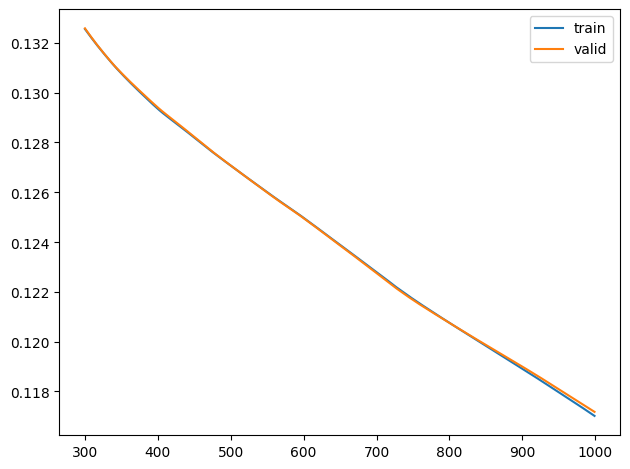

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
start_step = 300
ax.plot(range(start_step, nsteps), train_loss_history[start_step:nsteps], label = "train")
ax.plot(range(start_step, nsteps), valid_loss_history[start_step:nsteps], label = "valid")
# ax.plot(range(start_step, nsteps), test_loss_history[start_step:nsteps], label = "test")
ax.legend(loc="upper right")
fig.tight_layout()
fig.show()

In [9]:
print(jnp.acos(output[0][0]) * 180 / jnp.pi)
print(-jnp.log(output[0][1]))
print(-jnp.log(output[0][2]))

95.77193855608873
1.413202065428358
1.9980757689509432


In [10]:
print(u)

[-0.26724627  2.73907708]


In [11]:
from h2o.h2opes_analytic import water_pes
r_exact = 0.95
t_exact = 104.5 * jnp.pi / 180
theta = jnp.arange(jnp.pi/3, jnp.pi, 0.01)
bond = jnp.arange(0.8, 1.2, 0.005)
angle_vary = jnp.array([[r_exact, r_exact, t] for t in theta])
bond_vary = jnp.array([[r, r, t_exact] for r in bond])
batched_pes = jax.vmap(water_pes)
pes_angle_exact = batched_pes(angle_vary) / 1e4
pes_bond_exact = batched_pes(bond_vary) / 1e4

In [12]:
get_input = lambda x: jnp.array([jnp.cos(x[2]), jnp.exp(-x[0]), jnp.exp(-x[1])])
batched_input = jax.vmap(get_input)
angle_input = batched_input(angle_vary)
bond_input = batched_input(bond_vary)
angle_tau = flow_forward(params, angle_input)
bond_tau = flow_forward(params, bond_input)
transformed_pes = lambda tau: jnp.dot(u, basis(tau))
batched_pot = jax.vmap(transformed_pes)
pes_angle_reg = batched_pot(angle_tau)
pes_bond_reg = batched_pot(bond_tau)

/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_4507/3375021634.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_.show()


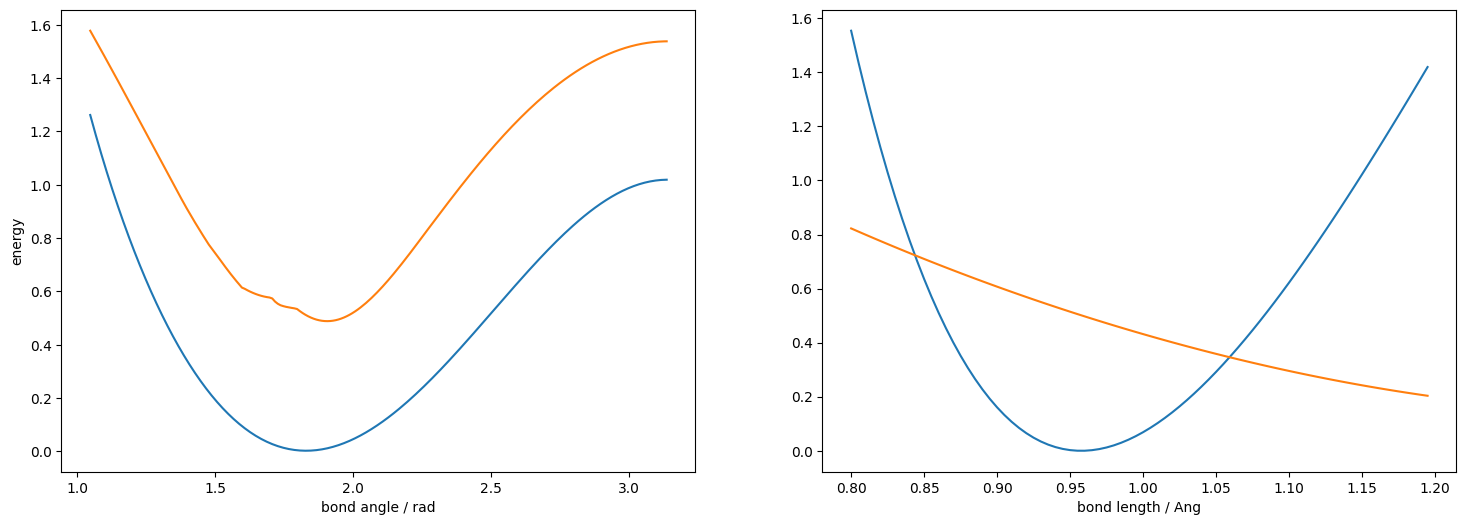

In [13]:
fig_ = plt.figure(figsize=(18, 6))
ax_ = fig_.subplots(1, 2)
ax_[0].plot(theta, pes_angle_exact)
ax_[0].plot(theta, pes_angle_reg)
ax_[0].set_xlabel("bond angle / rad")
ax_[0].set_ylabel("energy")
ax_[1].plot(bond, pes_bond_exact)
ax_[1].plot(bond, pes_bond_reg)
ax_[1].set_xlabel("bond length / Ang")
fig_.show()